In [593]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import scipy

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix

Para este exercíco foram geradas duas distribuições normais caracterizadas como ($\mu_1$, $\sigma_1$) e ($\mu_2$, $\sigma_2$), com 30 pontos cada ($N_1 = N_2 = 100$). Conforme o código a seguir:

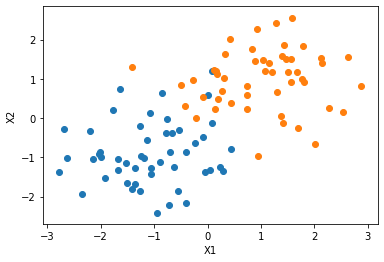

In [610]:
mu1 = [-1, -1]
sigma1 = [[0.7, 0], [0, 0.7]]  # diagonal covariance
N1 = 50
X_1 = np.random.multivariate_normal(mu1, sigma1, N1)

mu2 = [1, 1]
sigma2 = [[0.7, 0], [0, 0.7]]  # diagonal covariance
N2 = 50
X_2 = np.random.multivariate_normal(mu2, sigma2, N2)

plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.xlabel('X1')
plt.ylabel('X2')

#Todos os pontos
X = np.vstack((X_1, X_2))
#Classes de todos os pontos
Y = np.vstack((-1*np.ones((N1, 1)), np.ones((N2, 1))))
#Sepera as classes únicas
classes = np.unique(Y)

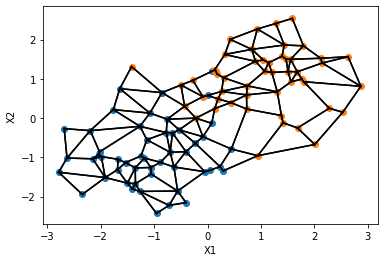

In [643]:
def GabrielGraph(X, Y):

    
    plt.scatter(X[np.where(Y == -1)[0],0], X[np.where(Y == -1)[0],1])
    plt.scatter(X[np.where(Y == 1)[0],0], X[np.where(Y == 1)[0],1])
    plt.xlabel('X1')
    plt.ylabel('X2')

    G = np.zeros((X.shape[0],X.shape[0]))

    D = distance_matrix(X, X)

    for i in range(X.shape[0]):
        xi = X[i,:]
        for j in range(X.shape[0]):
            xj = X[j,:]
            aux = 0
            for k in range(X.shape[0]):
                xk = X[k,:]
                if k == i or k == j:
                    continue
                if D[i][j]**2 <= (D[i][k]**2 + D[j][k]**2):
                    aux = aux + 1
            if(aux == (X.shape[0] - 2)):
                G[i,j] = 1
                x_values = [xi[0], xj[0]]
                y_values = [xi[1], xj[1]]
                plt.plot(x_values, y_values, 'k')
    return G
                
G = GabrielGraph(X, Y)

Support Edges:[[4, 51], [4, 63], [4, 80], [7, 70], [8, 55], [20, 59], [30, 59], [30, 81], [37, 59], [38, 53], [38, 59], [40, 60], [40, 65], [42, 54], [42, 70], [46, 55], [46, 81], [46, 91]]


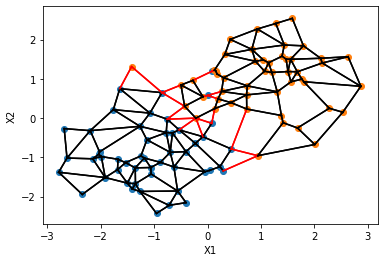

In [612]:
D_x = np.sum(G, axis = 1 )
D_x_classe1 = np.sum(G[0:int(N1),0:int(N1)], axis = 1 )
D_x_classe2 = np.sum(G[int(N1):G.shape[0],int(N1):G.shape[0]], axis = 1 )
D_x_classe = np.hstack((D_x_classe1,D_x_classe2))

q = D_x_classe/ D_x
    
Q_1 = q[0:D_x_classe1.shape[0],]
Q_2 = q[D_x_classe1.shape[0]:G.shape[0],]
t_1 = np.sum(Q_1)/Q_1.shape[0]
t_2 = np.sum(Q_2)/Q_2.shape[0]

indexesSV1 = np.where(q < t_1)
indexesSV2 = np.where(q < t_2)

#def GabrielGraph(X):

plt.scatter(X_1[:,0], X_1[:,1])
plt.scatter(X_2[:,0], X_2[:,1])
plt.xlabel('X1')
plt.ylabel('X2')

SE = []

for i in range(X.shape[0]):
    xi = X[i,:]
    for j in range(X.shape[0]):
        xj = X[j,:]
        if (G[i,j] == 1):
            x_values = [xi[0], xj[0]]
            y_values = [xi[1], xj[1]]
            if (Y[i]!=Y[j]):
                if [i,j] not in SE and [j,i] not in SE:
                    SE.append([i,j])
                plt.plot(x_values, y_values, 'r')
            else:
                plt.plot(x_values, y_values, 'k')
print('Support Edges:' + str(SE))

Support Edges:[[1, 76], [5, 44], [28, 50]]


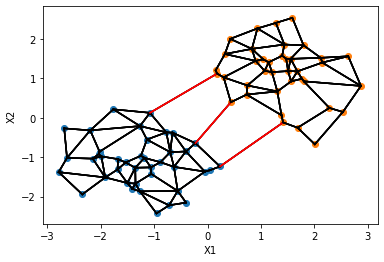

In [646]:
i = 0

X_NoOverlappin = X
Y_NoOverlappin = Y
for index in indexesSV1:
    X_NoOverlappin = np.delete(X, index - i, 0)
    Y_NoOverlappin = np.delete(Y, index - i, 0)
    i = i+1

G = GabrielGraph(X_NoOverlappin, Y_NoOverlappin)

SE_NoOverLapping = []

for i in range(X_NoOverlappin.shape[0]):
    xi = X_NoOverlappin[i,:]
    for j in range(X_NoOverlappin.shape[0]):
        xj = X_NoOverlappin[j,:]
        if (G[i,j] == 1):
            x_values = [xi[0], xj[0]]
            y_values = [xi[1], xj[1]]
            if (Y_NoOverlappin[i]!=Y_NoOverlappin[j]):
                if [i,j] not in SE_NoOverLapping and [j,i] not in SE_NoOverLapping:
                    SE_NoOverLapping.append([i,j])
                plt.plot(x_values, y_values, 'r')
            else:
                plt.plot(x_values, y_values, 'k')
print('Support Edges:' + str(SE_NoOverLapping))

In [647]:
m = np.zeros((len(SE_NoOverLapping), X_NoOverlappin.shape[1]))
i = 0
sigma = []
for edge in SE_NoOverLapping:
    m[i,:] = 0.5 * (X_NoOverlappin[edge[0],:] + X_NoOverlappin[edge[1],:])
    R = np.linalg.norm(X_NoOverlappin[edge[0]] - m[i,:]) 
    sigma.append([[R/3, 0],[0 ,  R/3]])
    i = i+1

In [651]:
def pNEstimativa(x, mu, cov):
    p = 1/np.sqrt((2*np.pi) ** mu.shape[0] * np.linalg.det(cov)) * np.exp(-0.5*(x - mu).transpose().dot(np.linalg.pinv(cov)).dot(x-mu))
    return p

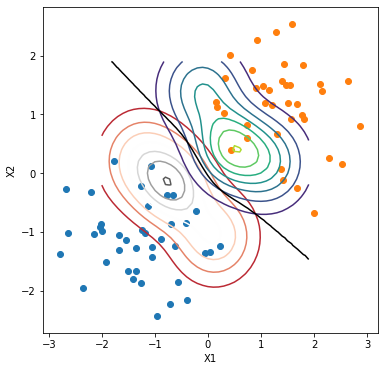

In [653]:

    X1 = X_NoOverlappin[np.where(Y_NoOverlappin == classes[0]),:][0]
    X2 = X_NoOverlappin[np.where(Y_NoOverlappin == classes[1]),:][0]


    x = np.arange(-2, 2, 0.1)
    y = np.arange(-2, 2, 0.1)
    
    dens1 = np.zeros((len(SE_NoOverLapping), x.shape[0], y.shape[0]))
    dens2 = np.zeros((len(SE_NoOverLapping), x.shape[0], y.shape[0]))

    Xmesh, Ymesh = np.meshgrid(x, y)

    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            for p in range(len(SE_NoOverLapping)):                   
                dens1[p,i,j] = pNEstimativa([x[i], y[j]], X_NoOverlappin[SE_NoOverLapping[p][0],:], sigma[p])
                dens2[p,i,j] = pNEstimativa([x[i], y[j]], X_NoOverlappin[SE_NoOverLapping[p][1],:], sigma[p])         

    fig, ax = plt.subplots(figsize=(6,6))

    ax.contour(x,y,np.sum(dens1, axis = 0), cmap='RdGy')
    ax.contour(x,y,np.sum(dens2, axis = 0))

    plt.scatter(X_NoOverlappin[np.where(Y_NoOverlappin == -1)[0],0], X_NoOverlappin[np.where(Y_NoOverlappin == -1)[0],1])
    plt.scatter(X_NoOverlappin[np.where(Y_NoOverlappin == 1)[0],0], X_NoOverlappin[np.where(Y_NoOverlappin == 1)[0],1])
    plt.xlabel('X1')
    plt.ylabel('X2')

    ax.contour(x,y,
           np.sum(dens1, axis = 0) - np.sum(dens2, axis = 0),
           levels=[0], cmap="Greys_r")

